In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install Required Libraries
!pip install transformers scikit-learn pandas torch

In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Load LLM

In [4]:
# Load PubMedBERT
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"  # BERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=59  # Placeholder for `num_labels`
)

# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load File

In [5]:
# Load Pre-split Datasets
train_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM-no-train.csv"
val_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM-no-val.csv"
test_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM-no-test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [6]:
# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['disease_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['disease_label'])

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['disease_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['disease_label'])

num_classes = len(label_encoder.classes_)

# Update ClinicalBERT Model for Classification
model.num_labels = num_classes  # Update number of labels

# Tokenize Symptoms

In [7]:
# Tokenize Symptoms
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_data['symptoms'])
val_encodings = tokenize_texts(val_data['symptoms'])
test_encodings = tokenize_texts(test_data['symptoms'])

# Convert labels to tensors
train_labels = torch.tensor(train_data['encoded_labels'].tolist())
val_labels = torch.tensor(val_data['encoded_labels'].tolist())
test_labels = torch.tensor(test_data['encoded_labels'].tolist())

# Dataset Class for Fine-Tuning
class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create PyTorch Datasets
train_dataset = SymptomDataset(train_encodings, train_labels)
val_dataset = SymptomDataset(val_encodings, val_labels)


# Fine-tuning BioBERT with LoRA

In [8]:
# Fine-Tuning BioBERT
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",  # Enable logging after a fixed number of steps
    logging_steps=10,  # Log training loss every 10 steps
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    num_train_epochs=6,
    weight_decay=0.001,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.026800,0.032234
2,0.000300,0.035731
3,0.005200,0.025833
4,0.000100,0.015484
5,0.000100,0.010349
6,0.000500,0.007920


TrainOutput(global_step=14022, training_loss=0.07610550045289886, metrics={'train_runtime': 698.9475, 'train_samples_per_second': 320.917, 'train_steps_per_second': 20.062, 'total_flos': 5996967621450624.0, 'train_loss': 0.07610550045289886, 'epoch': 6.0})

In [10]:
"""
# Save Fine-Tuned Model
model.save_pretrained("/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/fine_tuned_clinicalbert")
"""

'\n# Save Fine-Tuned Model\nmodel.save_pretrained("/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/fine_tuned_clinicalbert")\n'

# Generate ClinicalBERT Embedding for Random Forest

In [11]:
# Generate ClinicalBERT Embeddings
def generate_embeddings(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: batch[key].to(device) for key in ['input_ids', 'attention_mask']}
            outputs = model(**inputs)
            cls_embedding = outputs.logits.cpu().numpy()  # Extract logits for embedding
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

print("Generating embeddings for training data...")
train_embeddings = generate_embeddings(train_dataset)
print("Generating embeddings for validation data...")
val_embeddings = generate_embeddings(val_dataset)
print("Generating embeddings for testing data...")
test_embeddings = generate_embeddings(SymptomDataset(test_encodings, test_labels))

Generating embeddings for training data...
Generating embeddings for validation data...
Generating embeddings for testing data...


# UMAP (Uniform Manifold Approximation and Projection)

In [12]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00


Reducing dimensions using UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


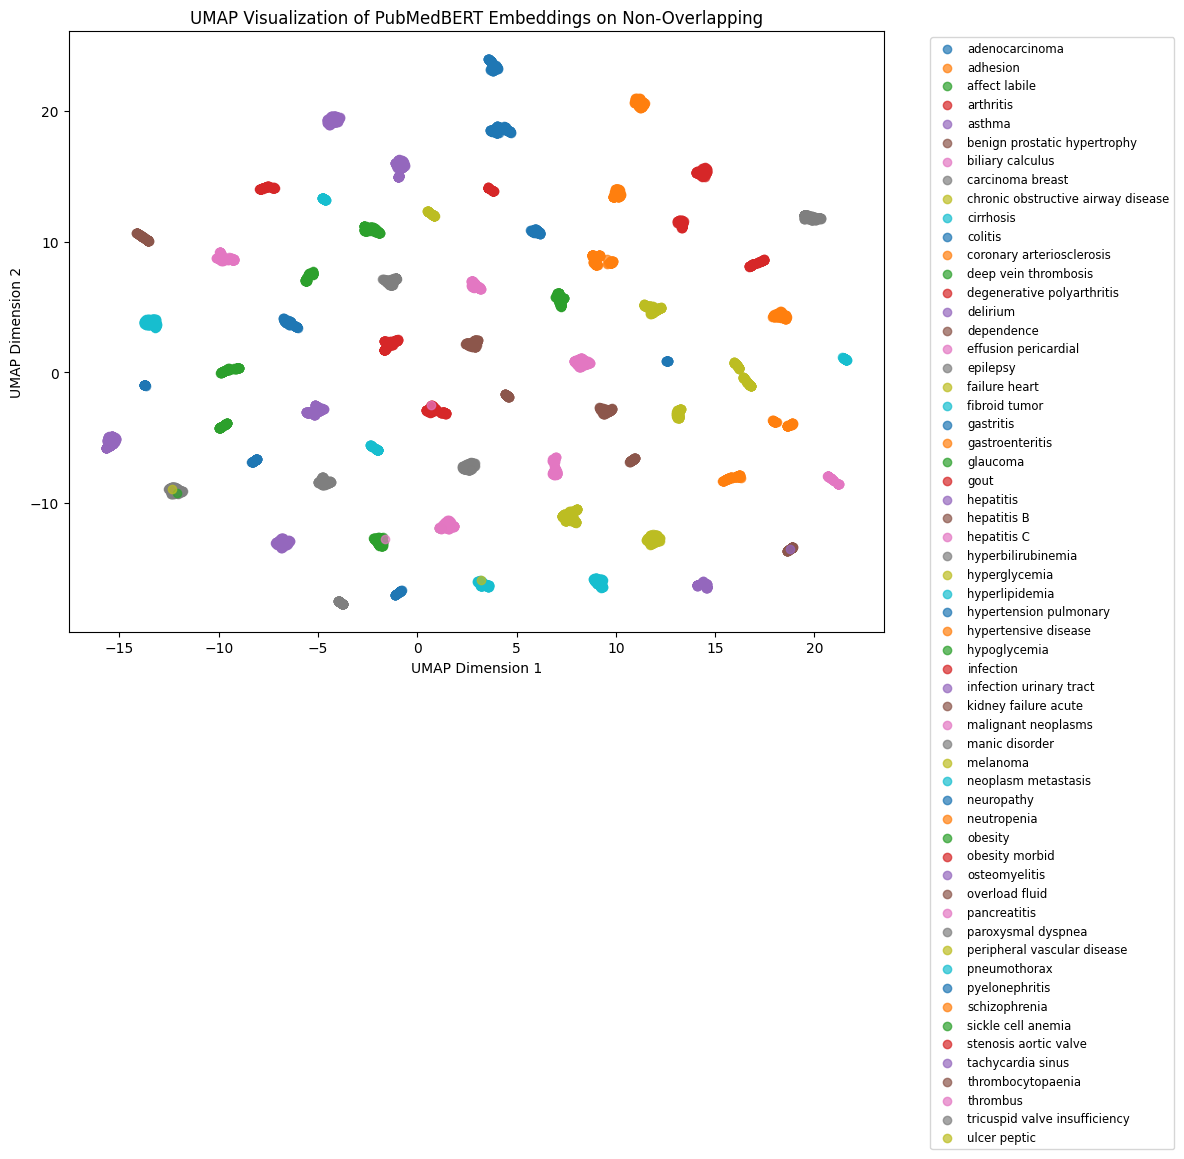

In [20]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Generate test embeddings (ensure this is executed before using UMAP)
# test_embeddings should already be generated using your generate_embeddings function.

# Convert test labels to NumPy for easier handling
labels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset

# Reduce dimensions using UMAP
print("Reducing dimensions using UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names

# Plot the 2D representation
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("UMAP Visualization of PubMedBERT Embeddings on Non-Overlapping")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()


# Naive Bayes

In [14]:
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           adenocarcinoma  adhesion  affect labile  arthritis  asthma  \
precision             1.0       1.0            1.0        1.0     1.0   
recall                1.0       1.0            1.0        1.0     1.0   
f1-score              1.0       1.0            1.0        1.0     1.0   
support             159.0     160.0           75.0      123.0    71.0   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           1.0          0.986486               1.0   
recall                              1.0          1.000000               1.0   
f1-score                            1.0          0.993197               1.0   
support                            75.0        146.000000             162.0   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                                 1.0    1.000000  ...   
recall                                    1.0    0.993827  ...   
f1-score             

In [15]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/PubMedBERT-nb-no-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/PubMedBERT-nb-no-class.csv


# Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
# Train Random Forest on Embeddings
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = rf_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = rf_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           adenocarcinoma  adhesion  affect labile  arthritis  asthma  \
precision             1.0       1.0            1.0        1.0     1.0   
recall                1.0       1.0            1.0        1.0     1.0   
f1-score              1.0       1.0            1.0        1.0     1.0   
support             159.0     160.0           75.0      123.0    71.0   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           1.0          0.986486               1.0   
recall                              1.0          1.000000               1.0   
f1-score                            1.0          0.993197               1.0   
support                            75.0        146.000000             162.0   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                                 1.0    1.000000  ...   
recall                                    1.0    0.993827  ...   
f1-score             

In [17]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/PubMedBERT-rf-no-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/PubMedBERT-rf-no-class.csv


# Support Vector Classifier

In [18]:
# Train Support Vector Classifier (SVC) on Embeddings
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = svc_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = svc_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           adenocarcinoma    adhesion  affect labile  arthritis  asthma  \
precision             1.0    1.000000            1.0        1.0     1.0   
recall                1.0    0.993750            1.0        1.0     1.0   
f1-score              1.0    0.996865            1.0        1.0     1.0   
support             159.0  160.000000           75.0      123.0    71.0   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           1.0          0.986486               1.0   
recall                              1.0          1.000000               1.0   
f1-score                            1.0          0.993197               1.0   
support                            75.0        146.000000             162.0   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                                 1.0    1.000000  ...   
recall                                    1.0    0.993827  ...   
f1-score   

In [19]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/PubMedBERT-svc-no-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/PubMedBERT-svc-no-class.csv
